In [1]:
# Data Handling and Manipulation
import pandas as pd
import numpy as np
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler

# Recommender Systems
from surprise import Reader, Dataset, KNNWithMeans, SVD, BaselineOnly
from surprise.model_selection import cross_validate

# Visualization
import matplotlib.pyplot as plt

# Utilities
from collections import Counter

# Assignment 3 - Hybrid Recommender System 
## LT2 - MSDS 2024 FT

Soliman, Jeremiah Dominic S.  
Uy, Kyle Christian F.   
Zabala, James Daniel B.   

# Data Loading and Initial Exploration

This assignment will revolve around the MovieLens dataset. We will be extracting insights from the data containing the users with their respective ratings. But, the main goal is to create a **Hybrid Recommender System** based on the concept of **Switching**. 

Let's start with loading the data. 

In [2]:
reviews = pd.read_csv('/mnt/data/public/movielens/latest/201809/small/'
                      'ml-latest-small/ratings.csv')
movies = pd.read_csv('/mnt/data/public/movielens/latest/201809/small/'
                     'ml-latest-small/movies.csv', index_col=0)

In the following cells, we'll be displaying some statistics for both reviews and movies. 

In [3]:
reviews.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [4]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


As an extra step, we did sanity checks for any duplicates. 

In [5]:
reviews[['userId', 'movieId']].drop_duplicates()

,userId,movieId
0,1,1
1,1,3
2,1,6
3,1,47
4,1,50
...,...,...
100831,610,166534
100832,610,168248
100833,610,168250
100834,610,168252


In [6]:
movies.describe()

,title,genres
count,9742,9742
unique,9737,951
top,Emma (1996),Drama
freq,2,1053


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9742 entries, 1 to 193609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   9742 non-null   object
 1   genres  9742 non-null   object
dtypes: object(2)
memory usage: 228.3+ KB


In [8]:
movies.drop_duplicates()

,title,genres
movieId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy
...,...,...
193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
193585,Flint (2017),Drama


At this point, we've completed the initial exploration of the dataset, gaining valuable insights and eliminating potential anomalies that could lead to erroneous findings. 

# Preprocessing

In the following cells, we'll do some pre-processing. This will make the data ready for processing later on in the creation of the recommender system. 

The data preprocessing done involves:
1. Regex
2. MultilabelBinarizer
3. Feature Engineering (Decade) 
4. Splitting a Holdout Set 

In [9]:
genre_list = movies['genres'].str.split('|')
year_list = movies['title'].str.extract(r'\((\d{4})\)').dropna().squeeze()
movies['year'] = pd.to_datetime(year_list).dt.year

`df_item_profile` will be used for the Content-Based Recommender System. 
The `df_utility` is the utility matrix that will be used for the Content-Based Recommender System and Popularity-based Recommender System.

In [10]:
mb = MultiLabelBinarizer()
scaler = MinMaxScaler()

item_profile = pd.DataFrame(
    mb.fit_transform(genre_list),
    columns=mb.classes_,
    index=movies.index
)
item_profile['decade'] = ((movies['year'] // 10) * 10)
item_profile['decade'] = scaler.fit_transform(item_profile[['decade']])
movies['decade'] = ((movies['year'] // 10) * 10)
unique_movies = reviews['movieId'].unique()
df_item_profile = item_profile.loc[unique_movies].copy()
reviews = reviews.drop(columns='timestamp')
utility = reviews.pivot(index='userId', columns='movieId', values='rating')
df_utility = utility.copy()

In [11]:
def remove_items(df_utility, user, L=10):
    """
    Randomly remove L items from a user's profile in the utility matrix.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    user : str
        User identifier.
    L : int
        Number of items to remove.

    Returns
    -------
    list of tuple
        A tuple containing the removed items and their original ratings.
    """
    removed_idx = {}
    rng = np.random.default_rng(0)
    while True:
        idx = rng.choice(df_utility.columns, replace=False)
        if np.isnan(df_utility.at[user, idx]):
            pass
        elif df_utility[idx].count() == 1:
            pass
        else:
            removed_idx[idx] = df_utility.at[user, idx]
            df_utility.at[user, idx] = np.nan

        if len(removed_idx) >= L:
            break

    return sorted(removed_idx.items(), key=lambda x: (-x[1]))

In [13]:
df_utility

movieId,1,2,3,4,5,6,7,8,9,10,...,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,2.5,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,2.5,2.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


`holdout` will be used as our holdout set that will be used for computing the NDCG. The NDCG will serve as our basis for 'Switching' the recommender system in place for that particular user. Ideally, all users will be subjected to the Hybrid Recommender System, but if a user is relatively new and rated or watched few movies, the recommended movies might not be accurate to that user's taste. So, for users with less than 30 ratings, we automatically place them in the Popularity-Based recommender system and they won't be subject to the Hybrid Recommender System. The holdout is composed of 10 movies chosen randomly together with their respective explicit rating. 

In [12]:
users = df_utility.index.tolist()

In [15]:
user_dict = {}

holdout = {}
for u in users:
    if df_utility.loc[u].count() < 30:
        user_dict[u] = 'popular'
        continue
    
    holdout[u] = remove_items(df_utility, u)

`df_reviews` will be used for other models trained like KNNwithMeans using the Surprise Package. 

In [14]:
df_reviews = (df_utility
              .reset_index()
              .melt('userId', value_name='rating')
              .dropna())

Now that the data is ready, we can proceed with gaining some extra insights about our data by asking some questions about it. 

# EDA

**Which genre appears the most in the dataset?**

More than 4,000 movies are Drama in the dataset with Comedy coming next at around 3,700 movies. Film-Noir has the least number of movies and there are also movies with no genres listed. 

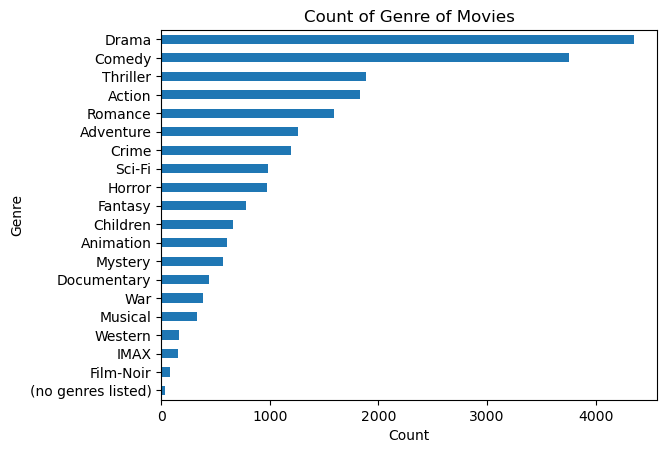

In [15]:
ax = df_item_profile.iloc[:, :-1].sum(axis=0).sort_values().plot.barh()
ax.set_title('Count of Genre of Movies')
ax.set_ylabel("Genre")
ax.set_xlabel("Count")
plt.show()

**After binning the years into their respective decade, to which decade does the movie belong to?**

Most of the movies in the dataset were release in the last 30 years while some of the movies date back to the 1900s. 

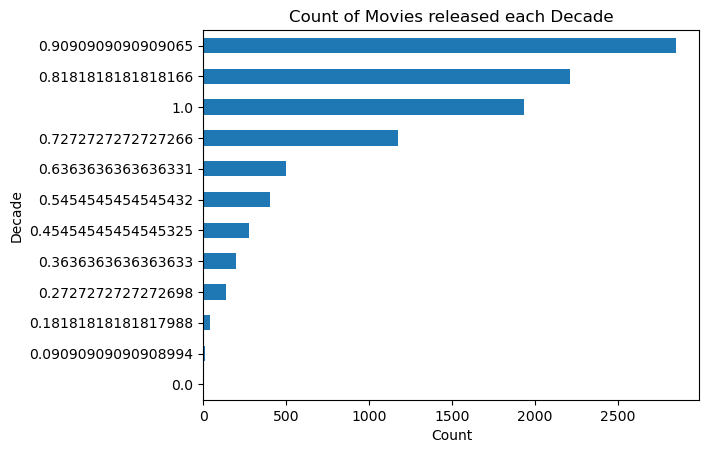

In [16]:
ax = df_item_profile.iloc[:, -1].value_counts().sort_values().plot.barh()
ax.set_title('Count of Movies released each Decade')
ax.set_ylabel("Decade")
ax.set_xlabel("Count")
plt.show()

**What movies were most rated?**

movieID 356 seems to have the most ratings exceeding 300 ratings. This movie may be a popular one. 

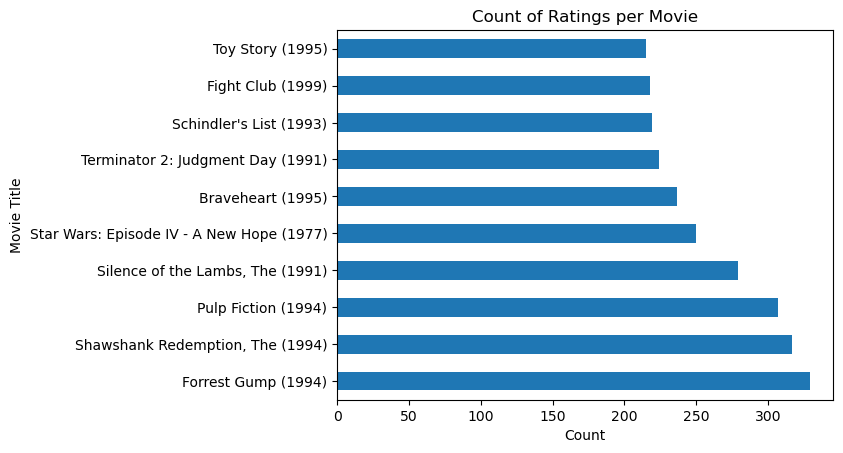

In [17]:
df_utility_title = df_utility.rename(movies.loc[df_utility.columns,
                                                "title"].to_dict(),
                                     axis=1).copy()
ax = df_utility_title.count(axis=0).sort_values(
    ascending=False).head(10).plot.barh()
ax.set_title("Count of Ratings per Movie")
ax.set_ylabel("Movie Title")
ax.set_xlabel("Count")
plt.show()

Forrest Gump is a classic that excels both in story and the perfect portrayal of Tom Hanks as the main character. Also important to note that this movie is both Comedy and Drama which had the most count in the categories.  

**Which decade had the most ratings?**

1990s was a popular decade for the users in this data. This may mean that the users of Movielens are on the older side. 

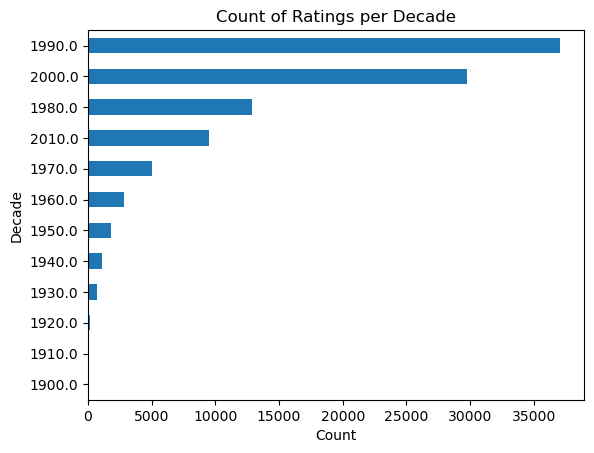

In [18]:
ax = (
    pd.merge(reviews, movies, how="left", left_on="movieId", right_index=True)
    .groupby("decade")
    .size()
    .sort_values()
    .plot.barh()
)
ax.set_title("Count of Ratings per Decade")
ax.set_ylabel("Decade")
ax.set_xlabel("Count")
plt.show()

**Which users rated the most movies?**

`userID 414` had rated more than 2500 movies with `userID 599` coming to a close second only more than 500 movies behind. 

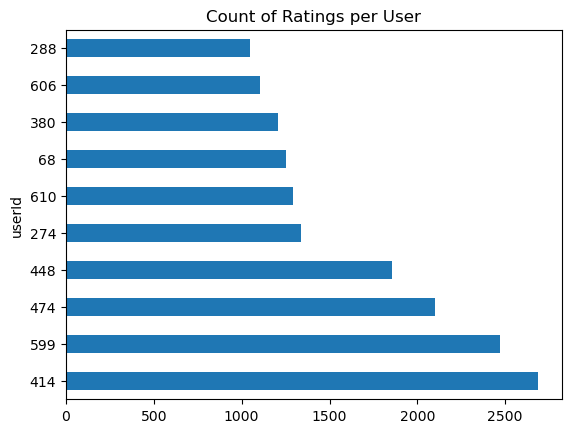

In [19]:
ax = (df_utility.count(axis=1).sort_values(
    ascending=False).head(10).plot.barh())
ax.set_title('Count of Ratings per User')
plt.show()

Now, we've gained extra insights about our data. These insights in itself can already provide value to the stakeholders and can form strategies in targeting their users. 

However, the main goal is to create a **Hybrid Recommender System**. The method that we'll be using is **Switching**. With this method, we'll be creating 3 Recommender Systems and base the "Switching" criterion on the NDCG for each user, whichever is highest. 

The three recommender systems are: 
1. Popularity-Based 
2. User-Based Collaborative Filtering 
3. Content-Based 

Read through the following cells, to see this in action. 

# Popularity-based

The first recommender system we developed is based on popularity. To rank the popularity of a movie, we set a criterion derived from our earlier EDA insight: the most popular movies are those with the highest number of ratings. `pop_list` is the list of `movieID`s sorted by this popularity criterion.

Users with less than 30 ratings will be automatically placed in this recommender system (explained in Preprocessing). 

In [20]:
pop_list = reviews['movieId'].value_counts().index.tolist()

In [21]:
pop_list

[356,
 318,
 296,
 593,
 2571,
 260,
 480,
 110,
 589,
 527,
 2959,
 1,
 1196,
 2858,
 50,
 47,
 780,
 150,
 1198,
 4993,
 1210,
 858,
 457,
 592,
 5952,
 2028,
 7153,
 588,
 608,
 2762,
 380,
 32,
 364,
 377,
 1270,
 4306,
 3578,
 1580,
 590,
 648,
 344,
 4226,
 367,
 6539,
 58559,
 595,
 1214,
 1036,
 500,
 165,
 79132,
 1265,
 1197,
 6377,
 1704,
 316,
 1291,
 2628,
 1721,
 153,
 1136,
 597,
 3793,
 231,
 1193,
 293,
 10,
 4886,
 6874,
 1089,
 7361,
 1240,
 1221,
 2329,
 34,
 1213,
 1200,
 8961,
 1682,
 541,
 4995,
 736,
 1097,
 5349,
 2683,
 733,
 1206,
 2716,
 5445,
 4973,
 1073,
 4963,
 586,
 1527,
 33794,
 587,
 5989,
 208,
 1968,
 185,
 5418,
 3147,
 3996,
 2,
 7438,
 349,
 1258,
 253,
 924,
 2918,
 4878,
 329,
 2115,
 48516,
 1208,
 4896,
 539,
 1732,
 68954,
 1923,
 111,
 223,
 39,
 60069,
 2706,
 161,
 357,
 6,
 778,
 1222,
 5816,
 434,
 292,
 454,
 912,
 44191,
 4022,
 1517,
 2997,
 104,
 339,
 3114,
 72998,
 2987,
 750,
 1617,
 6365,
 1784,
 1961,
 3949,
 59315,
 4027,
 25

In [22]:
def get_pop_ndcg(df_utility, pop_list, user, holdout):
    """
    Calculate the Normalized Discounted Cumulative Gain (NDCG)
    for popularity-based recommendations.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    pop_list : list
        List of popular items.
    user : str
        User identifier.
    holdout : dict
        Held out items of users.

    Returns
    -------
    float
        NDCG score.
    """
    sorted_pred_idx = [x for x in pop_list if x in dict(holdout[user]).keys()]
    sorted_removed = sorted(holdout[user], key=lambda x: (-x[1]))
    m = 1
    dcg = np.mean(
        [
            np.sum(
                [(2 ** dict(holdout[user])[k] - 1) for k in sorted_pred_idx]
                / np.log2(np.arange(len(sorted_pred_idx)) + 2)
            )
            for i in range(m)
        ]
    )
    idcg = np.mean(
        [
            np.sum(
                [(2**v - 1) for k, v in sorted_removed]
                / np.log2(np.arange(len(sorted_pred_idx)) + 2)
            )
            for i in range(m)
        ]
    )
    ndcg = dcg / idcg
    return ndcg

# Collaborative Filtering

The second recommender system we developed is a User-Based Collaborative Filtering. With this method, we tried two models from the **Surprise Package**: KNNWithMeans and SVD.

In [23]:
reader = Reader(rating_scale=(0,5))
dataset = Dataset.load_from_df(df_reviews, reader)

In [24]:
knn_u = KNNWithMeans(k=20, sim_options={'name': 'pearson', 'user_based': True})
cv_result = cross_validate(knn_u,
                           dataset,
                           measures=['rmse', 'mae'],
                           cv=5,
                           n_jobs=-1)
pd.DataFrame(cv_result).describe().loc['mean']

test_rmse    0.901675
test_mae     0.687640
fit_time     0.157489
test_time    0.768325
Name: mean, dtype: float64

In [25]:
svd = SVD(n_factors=100, random_state=0)
cv_result2 = cross_validate(svd,
                            dataset,
                            measures=['rmse', 'mae'],
                            cv=5,
                            n_jobs=-1)
pd.DataFrame(cv_result2).describe().loc['mean']

test_rmse    0.874639
test_mae     0.672888
fit_time     0.800058
test_time    0.113004
Name: mean, dtype: float64

As seen from the results above, SVD performed marginally better than KNNwithMeans in terms of RMSE and MAE. This is the reason that we picked SVD as our model for this recommender system.  
                                                                                                                                                    
We will then determine the estimated ratings for all unrated movies(items). These estimated ratings will serve as our basis when recommending using this User-Based Collaborative Filtering Recommender System. 

In [26]:
algo = svd.fit(dataset.build_full_trainset())
cf_pred = algo.test(algo.trainset.build_anti_testset())

In [27]:
df_cf = pd.DataFrame(cf_pred)

In [28]:
def get_cf_ndcg(df, user, holdout):
    """
    Calculate the Normalized Discounted Cumulative Gain (NDCG) for
    collaborative filtering recommendations.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing collaborative filtering predictions.
    user : str
        User identifier.
    holdout : dict
        Held out items of users.

    Returns
    -------
    float
        NDCG score.
    """
    sorted_pred_idx = (
        df.query(
            f"uid=={user} and iid in {list(dict(holdout[user]).keys())}"
        ).sort_values(by="est", ascending=False)
    )["iid"].tolist()
    sorted_removed = sorted(holdout[user], key=lambda x: (-x[1]))
    m = 1
    dcg = np.mean(
        [
            np.sum(
                [(2 ** dict(holdout[user])[k] - 1) for k in sorted_pred_idx]
                / np.log2(np.arange(len(sorted_pred_idx)) + 2)
            )
            for i in range(m)
        ]
    )
    idcg = np.mean(
        [
            np.sum(
                [(2**v - 1) for k, v in sorted_removed]
                / np.log2(np.arange(len(sorted_pred_idx)) + 2)
            )
            for i in range(m)
        ]
    )
    ndcg = dcg / idcg
    return ndcg

# Content-based

The third and last recommender system we developed is a Content-Based RS. With this method, we incorporated using the `Genre`, and the `Decade` for the content of our Movies.                                                                                                             

In [29]:
def compute_user_profile_agg_unary(df_utility, df_item_profiles, user):
    """
    Compute the aggregated user profile for unary ratings.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_item_profiles : pandas.DataFrame
        Item profile data.
    user : str
        User identifier.

    Returns
    -------
    pandas.Series
        Aggregated user profile.
    """
    user_mean = df_utility.loc[user].mean()
    idx = np.where(df_utility.loc[user] >= user_mean)[0]
    user_profile = df_item_profiles.iloc[idx].mean()
    return user_profile

In [30]:
def filled_agg_unary(df_utility, df_item_profiles, user_profile, user):
    """
    Fill user ratings based on aggregated unary user profile.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_item_profiles : pandas.DataFrame
        Item profile data.
    user_profile : pandas.Series
        Aggregated unary user profile.
    user : str
        User identifier.

    Returns
    -------
    dict
        Dictionary of item recommendations and their scores.
    """
    from scipy.spatial.distance import cosine
    nan_idx = np.isnan(df_utility.loc[user])
    items = df_item_profiles.loc[nan_idx]
    return {
        i: cosine(item, user_profile)
        for i, item in items.iterrows()
        if cosine(item, user_profile) > 0
    }


def get_unary_ndcg(df_utility, df_item_profile, user, holdout):
    """
    Calculate the Normalized Discounted Cumulative Gain (NDCG) for unary
    ratings.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_item_profile : pandas.DataFrame
        Item profile data.
    user : str
        User identifier.
    holdout:
        Held out items of users

    Returns
    -------
    float
        NDCG score.
    """
    user_profile_agg_unary = compute_user_profile_agg_unary(
        df_utility, df_item_profile, user)
    ratings = filled_agg_unary(df_utility, df_item_profile,
                               user_profile_agg_unary, user)
    pred = []
    for k, v in holdout[user]:
        pred.append((k, ratings[k]))
    sorted_pred_idx = [k for k, _ in sorted(pred, key=lambda x: (-x[1]))]
    sorted_removed = sorted(holdout[user], key=lambda x: (-x[1]))
    m = 1
    dcg = np.mean([
        np.sum([(2**dict(holdout[user])[k] - 1) for k in sorted_pred_idx] /
               np.log2(np.arange(len(sorted_pred_idx)) + 2)) for i in range(m)
    ])
    idcg = np.mean([
        np.sum([(2**v - 1) for k, v in sorted_removed] /
               np.log2(np.arange(len(sorted_pred_idx)) + 2)) for i in range(m)
    ])
    ndcg = dcg / idcg
    return ndcg

# Switching

With all the recommender systems in place, we can now proceed to determine the "Switching" criterion for our **Hybrid Recommender System**. The switching criterion is the NDCG for each user. However, not all users are subjected to Switching. To simplify, we included only users who have rated at least 30 movies in this Hybrid Recommender System. The reason is that users with fewer ratings haven't watched enough movies to provide a reasonable NDCG for the different recommender systems. Therefore, these users are automatically given Popularity-Based recommendations.

In [31]:
user_ndcg = {}
for u in holdout.keys():
    user_ndcg[u] = {}
    user_ndcg[u]['popular'] = get_pop_ndcg(df_utility, pop_list, u, holdout)
    user_ndcg[u]['cf'] = get_cf_ndcg(df_cf, u, holdout)
    user_ndcg[u]['cb'] = get_unary_ndcg(df_utility, df_item_profile, u,
                                        holdout)
    user_dict[u] = sorted(user_ndcg[u].items(), key=lambda x: (-x[1]))[0][0]

To clarify, for each user, we calculate the NDCG@10 for each recommender system. The switching mechanism involves selecting the model with the highest NDCG@10 and using that model to provide recommendations as seen on the dataframe below for the first 5 users. 

In [32]:
df_ndcg = pd.DataFrame(user_ndcg).T
df_ndcg.head()

,popular,cf,cb
1,0.837436,0.935729,0.869231
3,0.505499,0.620318,0.598037
4,0.854815,0.728783,0.844477
5,0.693121,0.828902,0.889554
6,0.978802,0.869105,0.907929


To further investigate, we want to see which recommender system is best for the users in this dataset. 

User-based collaborative filtering presents the highest NDCG average among the rest. Then, popularity-based came second followed by Content-Based. 

The NDCG is also a good score getting more than 80%. 

In [33]:
df_ndcg.describe()

,popular,cf,cb
count,501.000000,501.000000,501.000000
mean,0.859730,0.877780,0.836148
std,0.092090,0.089532,0.091444
min,0.505499,0.533583,0.508665
25%,0.802280,0.828902,0.779832
50%,0.873248,0.893118,0.847204
75%,0.934253,0.950494,0.904163
max,1.000000,1.000000,1.000000


However, for these set of users, the popularity-based recommender system got the most count. 

In [34]:
Counter(user_dict.values())

Counter({'popular': 263, 'cf': 233, 'cb': 114})

In [35]:
def get_cf_mae(df, user, holdout):
    """
    Calculate the Mean Absolute Error (MAE) for collaborative filtering
    recommendations.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing collaborative filtering predictions.
    user : str
        User identifier.
    holdout : dict
        Held out items of users.

    Returns
    -------
    float
        MAE score.
    """
    holdout_dict = dict(holdout[user])
    preds = df.query(f'uid=={user} and iid in {list(holdout_dict.keys())}')
    predictions = preds['est'].tolist()
    actuals = [holdout_dict[iid] for iid in preds['iid'].tolist()]
    mae = np.mean(np.abs(np.array(predictions) - np.array(actuals)))
    return mae

In [36]:
user_mae = {}
for u in holdout.keys():
    user_mae[u] = {}
    user_mae[u]['cf'] = get_cf_mae(df_cf, u, holdout)

In [37]:
pd.DataFrame(user_mae).T.describe()

,cf
count,501.000000
mean,0.683391
std,0.256010
min,0.215287
25%,0.496494
50%,0.641346
75%,0.821544
max,1.878533


As an extra step, we also checked the MAE for the for CF which gives us the predictions for the ratings. The mean absolute error for CF is 0.68, which is good considering that our ratings are scaled from 0-5. 

# Recommender

Now, we've set the correct recommender system for each user, we can now proceed with the recommendations. 

In [38]:
def recommend_popular(df, user, L=None):
    """
    Recommend popular items to a user.

    Parameters
    ----------
    df : pandas.DataFrame
        Utility matrix with user-item interactions.
    user : str
        User identifier.
    L : int, optional
        Number of items to recommend. If None, recommends items to fill 
        missing values.

    Returns
    -------
    list
        List of recommended items.
    """
    reco = []
    popular = pop_list.copy()
    if L is None:
        L = np.isnan(df_utility.loc[user]).sum()
    while len(reco) < L:
        item = popular.pop(0)
        if np.isnan(df.at[user, item]):
            reco.append(item)

    return reco

In [39]:
def recommend_cf(df, user, holdout, L=10):
    """
    Recommend items using collaborative filtering.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing collaborative filtering predictions.
    user : str
        User identifier.
    holdout : dict
        Held out items of users.
    L : int, optional
        Number of items to recommend. Default is 10.

    Returns
    -------
    list
        List of recommended items.
    """
    df_reco = (df
     .query(f'uid=={user} and iid not in {list(dict(holdout[user]).keys())}')
    )
    return pd.merge(df_reco,
                    pd.DataFrame(pop_list, columns=['iid']).reset_index(),
                    how='left', on='iid'
                   ).sort_values(by=['est', 'index'],
                                 ascending=[False, True]
                                ).head(L)['iid'].tolist()

In [40]:
def recommend_agg_unary(df_utility, df_item_prof, user_profile, user, L=10):
    """
    Recommend items using aggregated unary ratings.

    Parameters
    ----------
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_item_prof : pandas.DataFrame
        Item profile data.
    user_profile : pandas.Series
        Aggregated user profile.
    user : str
        User identifier.
    L : int, optional
        Number of items to recommend. Default is 10.

    Returns
    -------
    list
        List of recommended items.
    """
    from scipy.spatial.distance import cosine
    nan_idx = np.isnan(df_utility.loc[user])
    items = df_item_prof.loc[nan_idx]
    ratings = sorted([(i, cosine(item, user_profile))
                      for i, item in items.iterrows()
                      if cosine(item, user_profile) > 0],
                     key=lambda x: (x[1], x[0]))
    return [i for i, _ in ratings[:L]]

In [41]:
def reco_movies(user, user_dict, L, df_utility, df_cf, df_item_profile,
                holdout):
    """
    Recommend movies to a user based on the specified recommendation method.

    Parameters
    ----------
    user : str
        User identifier.
    user_dict : dict
        Dictionary mapping users to their preferred recommendation method.
    L : int
        Number of items to recommend.
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_cf : pandas.DataFrame
        DataFrame containing collaborative filtering predictions.
    df_item_profile : pandas.DataFrame
        Item profile data.
    holdout : dict
        Held out items of users.

    Returns
    -------
    list
        List of recommended items.
    """
    if user_dict[user] == "popular":
        return recommend_popular(df_utility, user, L=L)
    elif user_dict[user] == "cf":
        return recommend_cf(df_cf, user, holdout, L=L)
    else:
        user_profile = compute_user_profile_agg_unary(df_utility,
                                                      df_item_profile, user)
        return recommend_agg_unary(df_utility, df_item_profile, user_profile,
                                   u, L)

In [42]:
def get_titles(user,
               user_dict,
               L,
               df_utility,
               df_cf,
               df_item_profile,
               holdout,
               reco=True):
    """
    Get movie titles for a user based on recommendations or user ratings.

    Parameters
    ----------
    user : str
        User identifier.
    user_dict : dict
        Dictionary mapping users to their preferred recommendation method.
    L : int
        Number of items to recommend.
    df_utility : pandas.DataFrame
        Utility matrix with user-item interactions.
    df_cf : pandas.DataFrame
        DataFrame containing collaborative filtering predictions.
    df_item_profile : pandas.DataFrame
        Item profile data.
    holdout : dict
        Held out items of users.
    reco : bool, optional
        If True, generate recommendations; otherwise, use user ratings.
        Default is True.

    Returns
    -------
    pandas.DataFrame
        DataFrame containing movie titles.
    """
    if reco:
        list_reco = reco_movies(user, user_dict, L, df_utility, df_cf,
                                df_item_profile, holdout)
    else:
        list_reco = reviews[reviews['userId'] == user][[
            'movieId', 'rating'
        ]].sort_values('rating',
                       ascending=False).iloc[:10, :]['movieId'].tolist()
    return movies.loc[list_reco]

# Hybrid Recommender System in Action

This is the hybrid recommender system in action. For the User-Based CF, we merged the popularity-based dataset and sorted them by the ratings and then by the popularity to break any ties in the estimated ratings. 

Let's take a look at `userId = 1`. 

The first dataframe below shows his top rated movies (no particular order for ties). It consists of a lot of Action movies which are mostly Fiction like X-Men and Star Wars. 

The second dataframe below shows his top recommended movies. It aligns with his preferences with movies like Lord of the Rings, a bit similar to Star Wars. The Dark Knight also matches this description. 

In [43]:
user_dict[1]

'cf'

In [44]:
get_titles(1, user_dict, 10, df_utility, df_cf,
           df_item_profile, holdout, reco=False)

,title,genres,year,decade
movieId,,,,
2949,Dr. No (1962),Action|Adventure|Thriller,1962.0,1960.0
3703,"Road Warrior, The (Mad Max 2) (1981)",Action|Adventure|Sci-Fi|Thriller,1981.0,1980.0
3729,Shaft (1971),Action|Crime|Drama|Thriller,1971.0,1970.0
3793,X-Men (2000),Action|Adventure|Sci-Fi,2000.0,2000.0
151,Rob Roy (1995),Action|Drama|Romance|War,1995.0,1990.0
157,Canadian Bacon (1995),Comedy|War,1995.0,1990.0
163,Desperado (1995),Action|Romance|Western,1995.0,1990.0
216,Billy Madison (1995),Comedy,1995.0,1990.0
231,Dumb & Dumber (Dumb and Dumber) (1994),Adventure|Comedy,1994.0,1990.0


In [45]:
get_titles(1, user_dict, 10, df_utility, df_cf, df_item_profile, holdout)

,title,genres,year,decade
movieId,,,,
318,"Shawshank Redemption, The (1994)",Crime|Drama,1994.0,1990.0
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy,2002.0,2000.0
58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,2008.0,2000.0
1221,"Godfather: Part II, The (1974)",Crime|Drama,1974.0,1970.0
4995,"Beautiful Mind, A (2001)",Drama|Romance,2001.0,2000.0
48516,"Departed, The (2006)",Crime|Drama|Thriller,2006.0,2000.0
912,Casablanca (1942),Drama|Romance,1942.0,1940.0
5618,Spirited Away (Sen to Chihiro no kamikakushi) ...,Adventure|Animation|Fantasy,2001.0,2000.0
1201,"Good, the Bad and the Ugly, The (Buono, il bru...",Action|Adventure|Western,1966.0,1960.0


Below is a sample of the recommendations for a user tagged for the popularity-based recommender system. 

In [46]:
user_dict[2]

'popular'

In [47]:
get_titles(2, user_dict, 10, df_utility, df_cf,
           df_item_profile, holdout, reco=False)

,title,genres,year,decade
movieId,,,,
60756,Step Brothers (2008),Comedy,2008.0,2000.0
106782,"Wolf of Wall Street, The (2013)",Comedy|Crime|Drama,2013.0,2010.0
131724,The Jinx: The Life and Deaths of Robert Durst ...,Documentary,2015.0,2010.0
89774,Warrior (2011),Drama,2011.0,2010.0
80906,Inside Job (2010),Documentary,2010.0,2010.0
122882,Mad Max: Fury Road (2015),Action|Adventure|Sci-Fi|Thriller,2015.0,2010.0
58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,2008.0,2000.0
80489,"Town, The (2010)",Crime|Drama|Thriller,2010.0,2010.0
68157,Inglourious Basterds (2009),Action|Drama|War,2009.0,2000.0


In [48]:
get_titles(2, user_dict, 10, df_utility, df_cf, df_item_profile, holdout)

,title,genres,year,decade
movieId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War,1994.0,1990.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994.0,1990.0
593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991.0,1990.0
2571,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999.0,1990.0
260,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,1977.0,1970.0
480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,1993.0,1990.0
110,Braveheart (1995),Action|Drama|War,1995.0,1990.0
589,Terminator 2: Judgment Day (1991),Action|Sci-Fi,1991.0,1990.0
527,Schindler's List (1993),Drama|War,1993.0,1990.0


Below is a sample of the recommendations for a user tagged for the content-based recommender system. 

In [49]:
user_dict[607]

'cb'

In [50]:
get_titles(607, user_dict, 10, df_utility, df_cf,
           df_item_profile, holdout, reco=False)

,title,genres,year,decade
movieId,,,,
110,Braveheart (1995),Action|Drama|War,1995.0,1990.0
3755,"Perfect Storm, The (2000)",Drama|Thriller,2000.0,2000.0
1982,Halloween (1978),Horror,1978.0,1970.0
1997,"Exorcist, The (1973)",Horror|Mystery,1973.0,1970.0
2000,Lethal Weapon (1987),Action|Comedy|Crime|Drama,1987.0,1980.0
2194,"Untouchables, The (1987)",Action|Crime|Drama,1987.0,1980.0
2268,"Few Good Men, A (1992)",Crime|Drama|Thriller,1992.0,1990.0
3363,American Graffiti (1973),Comedy|Drama,1973.0,1970.0
318,"Shawshank Redemption, The (1994)",Crime|Drama,1994.0,1990.0


In [51]:
get_titles(607, user_dict, 10, df_utility, df_cf, df_item_profile, holdout)

,title,genres,year,decade
movieId,,,,
74916,Greenberg (2010),Comedy|Drama,2010.0,2010.0
78116,Please Give (2010),Comedy|Drama,2010.0,2010.0
79242,"Kids Are All Right, The (2010)",Comedy|Drama,2010.0,2010.0
80572,I'm Still Here (2010),Comedy|Drama,2010.0,2010.0
80693,It's Kind of a Funny Story (2010),Comedy|Drama,2010.0,2010.0
81831,"First Beautiful Thing, The (La prima cosa bell...",Comedy|Drama,2010.0,2010.0
83270,Made in Dagenham (2010),Comedy|Drama,2010.0,2010.0
83910,"Dilemma, The (2011)",Comedy|Drama,2011.0,2010.0
83976,"Trip, The (2010)",Comedy|Drama,2010.0,2010.0


# Acknowledgements 

Used ChatGPT for grammar checks and docstrings.